In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotnine as p9
from statsmodels.stats.multitest import fdrcorrection

from sklearn import preprocessing
from sklearn import metrics
import networkx as nx
import mantel

import pickle

In [5]:
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)

expr_scale = preprocessing.scale(expr.T, axis=0)
corr_pr = np.corrcoef(expr_scale)
corr_pr[corr_pr<0] = 0

#corr_pr = expr.corr(method='pearson').values
np.fill_diagonal(corr_pr, 0)
#corr_sp = expr.corr(method='spearman').values
#np.fill_diagonal(corr_sp, 0)

# Test1

In [6]:
def calc_strength_fraction(adj, set_S, set_T):
    W = adj[set_S, :][:, set_S].sum() + adj[set_T, :][:, set_T].sum()
    return W/(adj.sum()-W)

def generate_FDR_label(fdr_val):
    if fdr_val < 0.05:
        return f"* FDR={fdr_val:.4f}"
    else:
        return f"FDR={fdr_val:.4f}"

pr_dat_boxplot = []
pr_dat_scatter = []

subregion = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14]]
n_subregion = 4
n_perm = 1000
for i in range(n_subregion-1):
    for j in range(i+1, n_subregion):
        subregion_a = subregion[i]
        subregion_b = subregion[j]
        subregion_use = subregion_a + subregion_b

        corr_pr_use = corr_pr[subregion_use, :][:, subregion_use]
        corr_pr_use_nx = nx.from_numpy_array(corr_pr_use).to_undirected()

        ## calc index
        subregion_a = list(range(len(subregion_a)))
        subregion_b = list(range(len(subregion_a), len(subregion_use)))
        seg_index = np.array([ calc_strength_fraction(corr_pr_use, subregion_a, subregion_b),
                               nx.algorithms.conductance(corr_pr_use_nx, S=subregion_a, T=subregion_b, weight="weight"),
                               nx.algorithms.normalized_cut_size(corr_pr_use_nx, S=subregion_a, T=subregion_b, weight="weight") ])
        #print(i, j, seg_index)
        
        ## clac permutation index
        perm_index = np.empty(shape=(n_perm, 3))
        for k in range(n_perm):
            tmp_idx = np.random.permutation(corr_pr_use.shape[0])
            perm_corr = corr_pr_use[tmp_idx, :][:, tmp_idx]
            perm_corr_g = nx.from_numpy_array(perm_corr).to_undirected()

            perm_index[k, 0] = calc_strength_fraction(perm_corr, subregion_a, subregion_b)
            perm_index[k, 1] = nx.algorithms.conductance(perm_corr_g, S=subregion_a, T=subregion_b, weight="weight")
            perm_index[k, 2] = nx.algorithms.normalized_cut_size(perm_corr_g, S=subregion_a, T=subregion_b, weight="weight")

        pval = np.array([ (1+(perm_index[:, 0]>seg_index[0]).sum())/(1+n_perm),
                          (1+(perm_index[:, 1]<seg_index[1]).sum())/(1+n_perm),
                          (1+(perm_index[:, 2]<seg_index[2]).sum())/(1+n_perm) ])
        #print(i, j, pval)
        _, fdr = fdrcorrection(pval, alpha=0.05, method="indep", is_sorted=False)
        #print(i, j, fdr)
        
        pr_dat_scatter.append([f"INS {i+1}-{j+1}", "Strength fraction", seg_index[0], generate_FDR_label(fdr[0]), np.quantile(perm_index[:, 0], 0.99)*1.01])
        pr_dat_scatter.append([f"INS {i+1}-{j+1}", "Conductance", seg_index[1],generate_FDR_label(fdr[1]), np.quantile(perm_index[:, 1], 0.99)*1.01])
        pr_dat_scatter.append([f"INS {i+1}-{j+1}", "Normalized cut", seg_index[2], generate_FDR_label(fdr[2]), np.quantile(perm_index[:, 2], 0.99)*1.01])

        perm_index = pd.DataFrame(perm_index, columns=["Strength fraction", "Conductance", "Normalized cut"])
        perm_index["Verse"] = f"INS {i+1}-{j+1}"
        pr_dat_boxplot.append(perm_index)
        #break
    #break

/tmp/ipykernel_30742/4099183179.py:3: RuntimeWarning: divide by zero encountered in double_scalars


In [7]:
pr_dat_boxplot = pd.concat(pr_dat_boxplot).melt(var_name="Index", value_name="Value", id_vars=["Verse"])
pr_dat_boxplot

,Verse,Index,Value
0,INS 1-2,Strength fraction,0.514522
1,INS 1-2,Strength fraction,0.793390
2,INS 1-2,Strength fraction,1.654316
3,INS 1-2,Strength fraction,0.347832
4,INS 1-2,Strength fraction,1.034830
...,...,...,...
17995,INS 3-4,Normalized cut,1.317180
17996,INS 3-4,Normalized cut,1.034934
17997,INS 3-4,Normalized cut,1.138531
17998,INS 3-4,Normalized cut,1.181592


In [8]:
pr_dat_scatter = pd.DataFrame(pr_dat_scatter, columns=["Verse", "Index", "Value", "FDR", "y"])
pr_dat_scatter

,Verse,Index,Value,FDR,y
0,INS 1-2,Strength fraction,2.228430,FDR=0.0939,4.272562e+00
1,INS 1-2,Conductance,0.348002,FDR=0.0939,9.297702e-01
2,INS 1-2,Normalized cut,0.627073,FDR=0.0939,1.600909e+00
3,INS 1-3,Strength fraction,1.081377,FDR=0.1389,1.614168e+01
4,INS 1-3,Conductance,0.603857,FDR=0.1389,8.577148e-01
5,INS 1-3,Normalized cut,1.002783,FDR=0.1389,1.537671e+00
6,INS 1-4,Strength fraction,24.495485,* FDR=0.0330,8.473703e+15
7,INS 1-4,Conductance,0.046201,* FDR=0.0330,1.010000e+00
8,INS 1-4,Normalized cut,0.080277,* FDR=0.0330,1.701232e+00
9,INS 2-3,Strength fraction,1.266620,FDR=0.2058,8.334865e+00


/mnt/d/workdir_for_Linux/software/Miniconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 7 rows containing non-finite values.


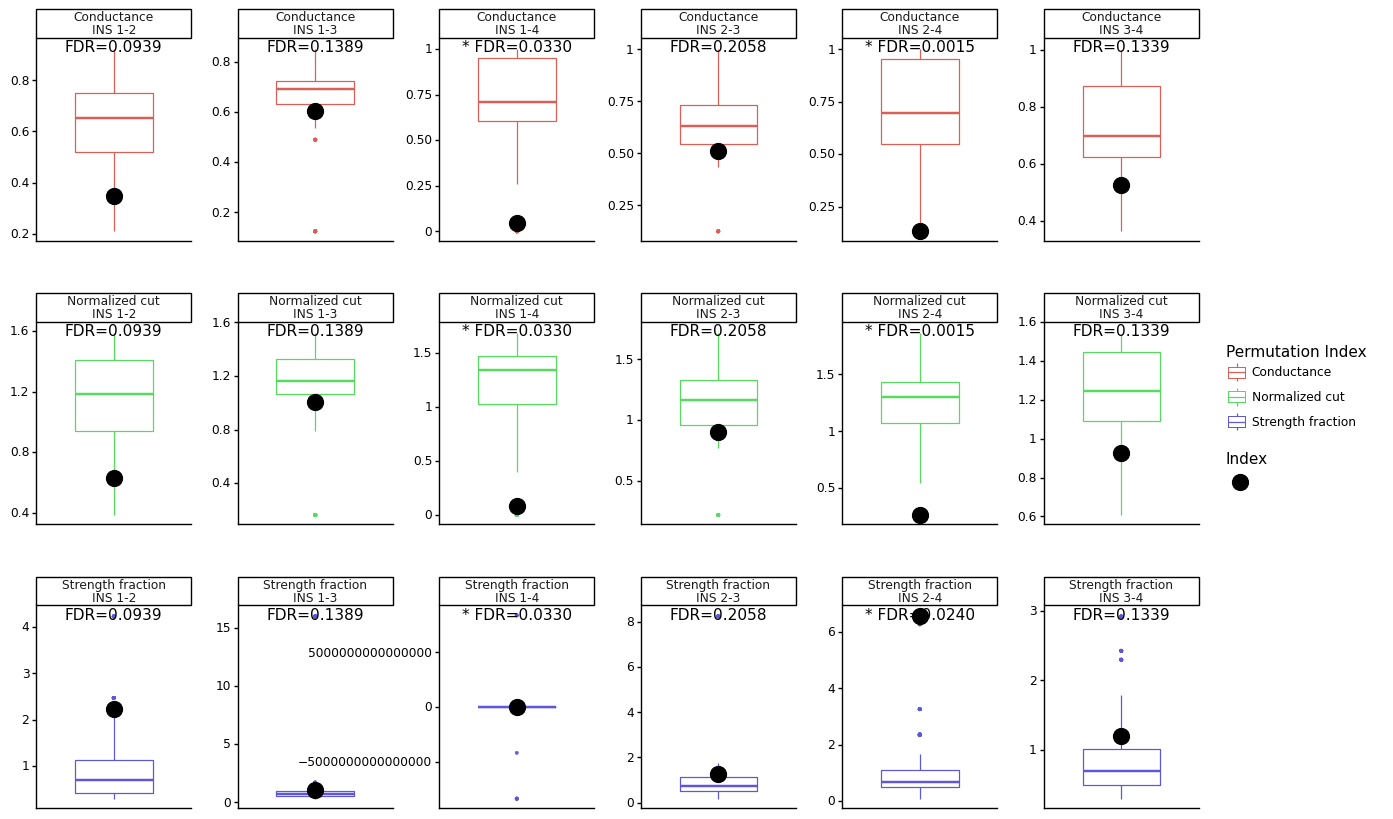

<ggplot: (8745409099472)>

In [9]:
pr_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index",), pr_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="o", outlier_alpha=0.5, outlier_size=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=pr_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), pr_dat_scatter, color="black")
  + p9.facet_wrap("~Index+Verse", nrow=3, ncol=6, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30, 'hspace':0.4},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black"),
             figure_size=(15, 10)
            )
)
#p9.ggsave(pr_plot, "../res/pr_plot.pdf", units="in", width=6, height=4, verbose=False )
pr_plot

# Test2

In [10]:
def calc_strength_fraction(adj, set_S, set_T):
    W_i = adj[set_S, :][:, set_S].sum() + adj[set_T, :][:, set_T].sum()
    W = adj[:4, :4].sum()+adj[4:8, 4:8].sum()+adj[8:12, 8:12].sum()+adj[12:, 12:].sum()
    return W_i/(adj.sum()-W)

def calc_conductance(nx_adj, set_S, set_T):
    return nx.algorithms.conductance(nx_adj, set_S, weight="weight") + nx.algorithms.conductance(nx_adj, set_T, weight="weight")

def calc_normalized_cut(nx_adj, set_S, set_T):
    return nx.algorithms.normalized_cut_size(nx_adj, set_S, weight="weight") + nx.algorithms.normalized_cut_size(nx_adj, set_T, weight="weight")

def generate_FDR_label(fdr_val):
    if fdr_val < 0.05:
        return f"* FDR={fdr_val:.4f}"
    else:
        return f"FDR={fdr_val:.4f}"


corr_pr_nx = nx.from_numpy_array(corr_pr).to_undirected()

pr_dat_boxplot = []
pr_dat_scatter = []
subregion = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14]]
n_subregion = 4
n_perm = 1000
for i in range(n_subregion-1):
    for j in range(i+1, n_subregion):
        subregion_a = subregion[i]
        subregion_b = subregion[j]

        ## calc index
        seg_index = np.array([ calc_strength_fraction(corr_pr, subregion_a, subregion_b),
                               calc_conductance(corr_pr_nx, subregion_a, subregion_b),
                               calc_normalized_cut(corr_pr_nx, subregion_a, subregion_b) ])
        #print(i, j, seg_index)
        
        ## clac permutation index
        perm_index = np.empty(shape=(n_perm, 3))
        for k in range(n_perm):
            tmp_idx = np.random.permutation(corr_pr.shape[0])
            perm_corr = corr_pr[tmp_idx, :][:, tmp_idx]
            perm_corr_g = nx.from_numpy_array(perm_corr).to_undirected()

            perm_index[k, 0] = calc_strength_fraction(perm_corr, subregion_a, subregion_b)
            perm_index[k, 1] = calc_conductance(perm_corr_g, subregion_a, subregion_b)
            perm_index[k, 2] = calc_normalized_cut(perm_corr_g, subregion_a, subregion_b)
        
        pval = np.array([ (1+(perm_index[:, 0]>seg_index[0]).sum())/(1+n_perm),
                          (1+(perm_index[:, 1]<seg_index[1]).sum())/(1+n_perm),
                          (1+(perm_index[:, 2]<seg_index[2]).sum())/(1+n_perm) ])
        #print(i, j, pval)
        _, fdr = fdrcorrection(pval, alpha=0.05, method="indep", is_sorted=False)
        #print(i, j, fdr)
        #fdr = pval
        pr_dat_scatter.append([f"INS {i+1}-{j+1}", "Strength fraction", seg_index[0], generate_FDR_label(fdr[0]), np.quantile(perm_index[:, 0], 0.99)*1.01])
        pr_dat_scatter.append([f"INS {i+1}-{j+1}", "Conductance", seg_index[1],generate_FDR_label(fdr[1]), np.quantile(perm_index[:, 1], 0.99)*1.01])
        pr_dat_scatter.append([f"INS {i+1}-{j+1}", "Normalized cut", seg_index[2], generate_FDR_label(fdr[2]), np.quantile(perm_index[:, 2], 0.99)*1.01])

        perm_index = pd.DataFrame(perm_index, columns=["Strength fraction", "Conductance", "Normalized cut"])
        perm_index["Verse"] = f"INS {i+1}-{j+1}"
        pr_dat_boxplot.append(perm_index)
        #break
    #break

In [11]:
pr_dat_boxplot = pd.concat(pr_dat_boxplot).melt(var_name="Index", value_name="Value", id_vars=["Verse"])
pr_dat_boxplot

,Verse,Index,Value
0,INS 1-2,Strength fraction,0.147963
1,INS 1-2,Strength fraction,0.154079
2,INS 1-2,Strength fraction,0.098071
3,INS 1-2,Strength fraction,0.106157
4,INS 1-2,Strength fraction,0.134585
...,...,...,...
17995,INS 3-4,Normalized cut,2.244604
17996,INS 3-4,Normalized cut,1.973339
17997,INS 3-4,Normalized cut,1.911504
17998,INS 3-4,Normalized cut,1.956915


In [12]:
pr_dat_scatter = pd.DataFrame(pr_dat_scatter, columns=["Verse", "Index", "Value", "FDR", "y"])
pr_dat_scatter

,Verse,Index,Value,FDR,y
0,INS 1-2,Strength fraction,0.402913,* FDR=0.0120,0.392482
1,INS 1-2,Conductance,1.089263,* FDR=0.0120,1.908051
2,INS 1-2,Normalized cut,1.477008,* FDR=0.0120,2.609226
3,INS 1-3,Strength fraction,0.335220,FDR=0.0929,0.402462
4,INS 1-3,Conductance,1.307536,FDR=0.1119,1.935359
5,INS 1-3,Normalized cut,1.834685,FDR=0.1119,2.647995
6,INS 1-4,Strength fraction,0.403623,* FDR=0.0050,0.343929
7,INS 1-4,Conductance,0.985243,* FDR=0.0030,1.988257
8,INS 1-4,Normalized cut,1.307604,* FDR=0.0030,2.588680
9,INS 2-3,Strength fraction,0.271055,FDR=0.0979,0.404026


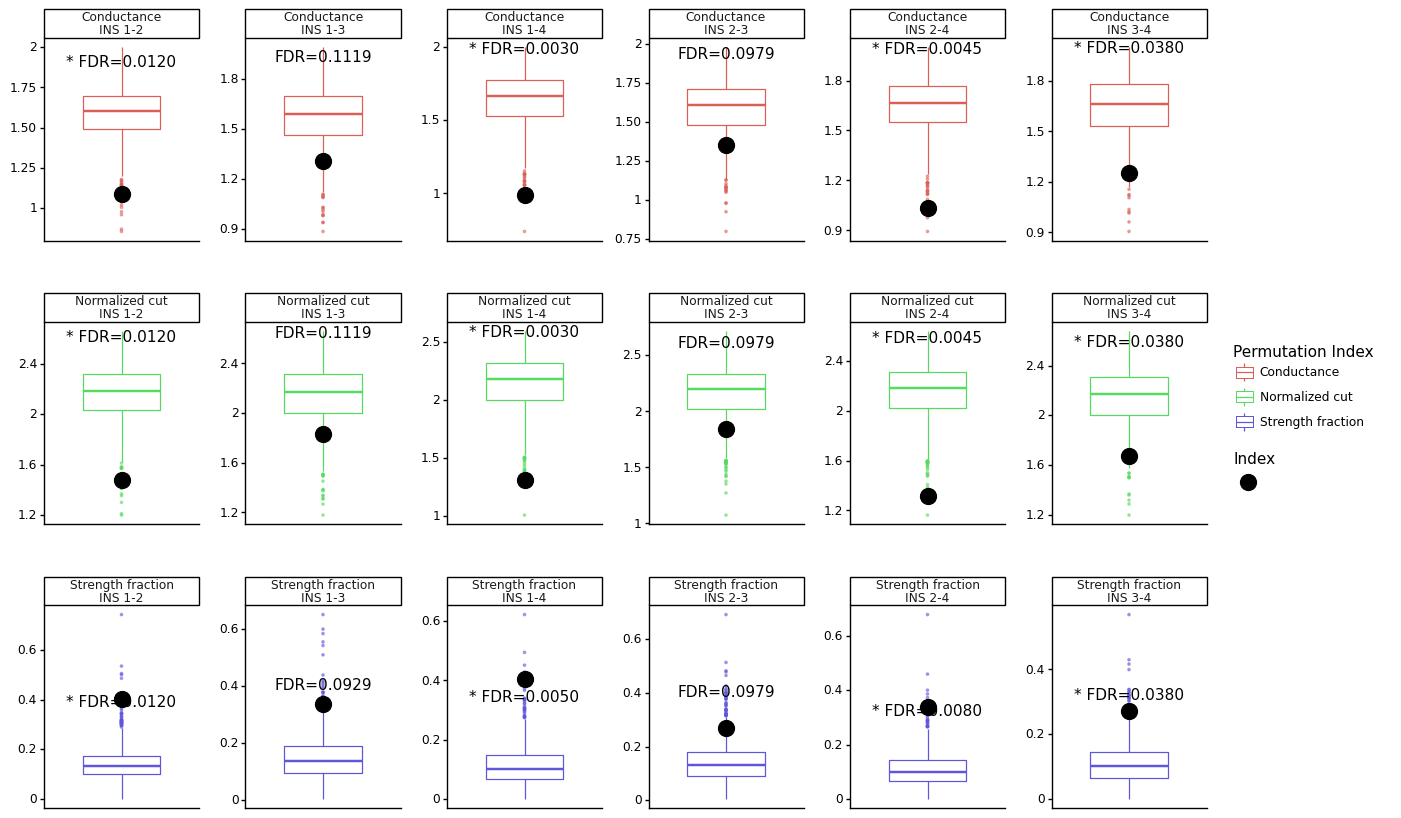

<ggplot: (8745401744677)>

In [13]:
pr_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index",), pr_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="o", outlier_alpha=0.5, outlier_size=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=pr_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), pr_dat_scatter, color="black")
  + p9.facet_wrap("~Index+Verse", nrow=3, ncol=6, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30, 'hspace':0.4},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black"),
             figure_size=(15, 10)
            )
)
#p9.ggsave(pr_plot, "../res/pr_plot.pdf", units="in", width=6, height=4, verbose=False )
pr_plot

In [75]:
pr_dat_scatter.sort_values(by=["Value"])

,Verse,Index,Value,FDR,y
6,INS 1-4,Strength fraction,0.106652,FDR=0.6124,0.112208
15,INS 3-4,Strength fraction,0.109292,FDR=0.1548,0.111969
12,INS 2-4,Strength fraction,0.110831,* FDR=0.0120,0.111963
3,INS 1-3,Strength fraction,0.144389,FDR=0.3497,0.149150
0,INS 1-2,Strength fraction,0.145927,FDR=0.1139,0.149357
9,INS 2-3,Strength fraction,0.148567,* FDR=0.0090,0.149083
10,INS 2-3,Conductance,1.562365,* FDR=0.0150,1.596736
1,INS 1-2,Conductance,1.565408,FDR=0.1139,1.596786
4,INS 1-3,Conductance,1.569465,FDR=0.3497,1.596766
13,INS 2-4,Conductance,1.632937,* FDR=0.0060,1.669214


In [14]:
pr_dat_scatter.loc[pr_dat_scatter["Index"]=="Strength fraction"].sort_values(by=["Value"])

,Verse,Index,Value,FDR,y
9,INS 2-3,Strength fraction,0.271055,FDR=0.0979,0.404026
15,INS 3-4,Strength fraction,0.271765,* FDR=0.0380,0.321890
3,INS 1-3,Strength fraction,0.335220,FDR=0.0929,0.402462
12,INS 2-4,Strength fraction,0.339458,* FDR=0.0080,0.326052
0,INS 1-2,Strength fraction,0.402913,* FDR=0.0120,0.392482
6,INS 1-4,Strength fraction,0.403623,* FDR=0.0050,0.343929


In [15]:
pr_dat_scatter.loc[pr_dat_scatter["Index"]=="Conductance"].sort_values(by=["Value"])

,Verse,Index,Value,FDR,y
7,INS 1-4,Conductance,0.985243,* FDR=0.0030,1.988257
13,INS 2-4,Conductance,1.033249,* FDR=0.0045,1.988285
1,INS 1-2,Conductance,1.089263,* FDR=0.0120,1.908051
16,INS 3-4,Conductance,1.251522,* FDR=0.0380,1.995181
4,INS 1-3,Conductance,1.307536,FDR=0.1119,1.935359
10,INS 2-3,Conductance,1.355542,FDR=0.0979,1.938435


In [16]:
pr_dat_scatter.loc[pr_dat_scatter["Index"]=="Normalized cut"].sort_values(by=["Value"])

,Verse,Index,Value,FDR,y
8,INS 1-4,Normalized cut,1.307604,* FDR=0.0030,2.588680
14,INS 2-4,Normalized cut,1.316174,* FDR=0.0045,2.584446
2,INS 1-2,Normalized cut,1.477008,* FDR=0.0120,2.609226
17,INS 3-4,Normalized cut,1.673851,* FDR=0.0380,2.589520
5,INS 1-3,Normalized cut,1.834685,FDR=0.1119,2.647995
11,INS 2-3,Normalized cut,1.843255,FDR=0.0979,2.613696
